<a href="https://colab.research.google.com/github/arnabksarkar/LLMFinetuning/blob/main/FineTune_Gemma_for_Bengali_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gemma_language_tuning_path = kagglehub.competition_download('gemma-language-tuning')
arnabkarsarkar_bengali_culture_history_wiki_path = kagglehub.dataset_download('arnabkarsarkar/bengali-culture-history-wiki')
keras_gemma2_keras_gemma2_instruct_2b_en_1_path = kagglehub.model_download('keras/gemma2/Keras/gemma2_instruct_2b_en/1')

print('Data source import complete.')


100%|██████████| 646/646 [00:00<00:00, 397kB/s]

Extracting files...


100%|██████████| 800k/800k [00:00<00:00, 71.6MB/s]

Extracting files...


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/config.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/tokenizer.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/metadata.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/model.weights.h5
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/assets/tokenizer/vocabulary.spm


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Introduction

Gemma is a family of open-source large language models (LLMs) developed by Google. It's designed to be accessible and flexible, allowing developers and researchers to experiment with AI capabilities on various devices, from consumer-grade GPUs to CPUs. Gemma comes in different sizes (2B and 7B parameters) and variants (base and instruction-tuned) to suit different needs and applications.


In this notebook, I am going to show a methodology for fine-tuning the Gemma2 language model to understand Bengali history & culture, addressing a key gap in handling regional languages. I do not believe we have an easy way to fine tune any LLM model in reginonal languagages. Using Bengali texts as our test case, we can show that this methodology can be adapted for any language.

I've structured this as a practical, reproducible guide that takes you from initial setup to a fully functional model capable of translating standard text into authentic slang. While I use Bengali examples throughout (marked in *italics*), the core principles and technical approaches apply universally.

The instructions are written in English to make this resource accessible to a broader technical audience, with clear documentation of each step in the fine-tuning process.

# Data Curation

## Data Source Selection

I chose **Wikipedia** as the primary data source due to its extensive coverage and multilingual content.The choice was driven by the scarcity of readily available, high-quality Bengali language datasets

Wikipedia's standardized format and reliable content quality made it an ideal source for training data




### Download the data from Wikipedia

Here I have used the *Bengali* culture pages from Wikipedia website and extracted the contents.

Below is a pseudo code for the same

In [ ]:
# Below code will extract all links from the Wiki pages going upto 5 level depth.

# def extract_links_from_webpage(url):
#     """Extracts all links from a given webpage URL."""

#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Raise an exception for bad status codes

#         soup = BeautifulSoup(response.content, 'html.parser')
#         body = soup.find("div", {"id": "bodyContent"})
#         if body:
#             links = [a['href'] for a in body.find_all('a', href=True)]
#         else:
#             links = []

#         return links

#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return []



# maxDepth = 5 # Set the maximum depth to traverse child pages


# baseURL = 'https://en.wikipedia.org/wiki/Culture_of_Bengal'

# allLinks = []
# visitedLinks = set()  # To keep track of visited links

# def crawl_and_extract_links(url, depth):
#     if depth > maxDepth or url in visitedLinks:
#         return
#     visitedLinks.add(url)

#     try:
#         links = extract_links_from_webpage(url)
#         for link in links:
#             if link.endswith('.jpg') or link.endswith('.png') or link.endswith('.gif') or link.endswith('.svg'):
#                 continue
#             if link.startswith('#'):
#                 continue
#             if '/wiki/Category:' in link:
#                 continue
#             if '/Help:Category' in link:
#                 continue
#             if link.startswith('/'):
#                 link = 'https://en.wikipedia.org' + link
#             allLinks.append(link)
#             visitedLinks.add(link)
#             crawl_and_extract_links(link, depth + 1)
#     except Exception as e:
#         print(f"Error processing {url}: {e}")


# crawl_and_extract_links(baseURL, 0)
# allLinks = list(set(allLinks))
# allLinks.append(baseURL)
# print("Extracted Links size:" + str(len(allLinks)))

In [ ]:
## This code will extract the text from each of the links from above websites.

# def extract_text_from_webpage(url):
#     """Extracts text content from a given webpage URL and saves it to a text file."""

#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Raise an exception for bad status codes

#         soup = BeautifulSoup(response.content, 'html.parser')
#         title = soup.title.string if soup.title else "Webpage_NO_Title" + random.randint(10, 99)

#         print(f"Title of the webpage: {title}")

#         # Extract all text from <p> tags
#         text_content = " ".join([p.get_text() for p in soup.find_all('p')])

#         # Save the extracted text to a file
#         with open('all_bengali_culture_texts/' + title + '.txt', 'w', encoding='utf-8') as file:
#             file.write(text_content)

#         print(f"Text extracted and saved for {title}")

#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")

### Create Alpaca dataset using Gemini

I've used Google's most advanced LLM model Gemini1.5 to translate the text and generate Alpaca dataset. Below is the code for the same

In [ ]:
# # Import the genAI library
# import google.generativeai as genai

# # for Kaggle secrects
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# GOOGLE_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")

# #configure
# genai.configure(api_key=GOOGLE_API_KEY)



In this below code I have used the prompt to Translate all the texts into *Bengali*.

In [ ]:
# def translate_text(text, target_language="bangla"):
#     try:
#         model = genai.GenerativeModel("gemini-1.5-pro-001")
#         response = model.generate_content(
#             f"Translate the following text to {target_language}:\n\n{text}",
#             generation_config = genai.GenerationConfig(
#                                     max_output_tokens=1000,
#                                     temperature=0.1,
#                                 )
#         )
#         return response.text
#     except Exception as e:
#         print(f"Error during translation: {e}")
#         return None


# translated_files = []
# for file_info in files_data:
#     translated_text = translate_text(file_info['content'])
#     print(f"translation done for file {file_info['filename']}")
#     if translated_text:
#         translated_files.append({
#             'filename': file_info['filename'],
#             'original_text': file_info['content'],
#             'translated_text': translated_text
#         })
#     else:
#         print(f"Skipping translation for {file_info['filename']} due to error.")

# print(f'translated file sizes {len(translated_files)}')

Once all the translation is completed, we can proceed to create the Alapaca dataset.

I have used the below **Bengali** prompt to generate the dataset.

> *prompt_text = প্রদত্ত পাঠ্য থেকে Alpaca ফরম্যাটে একটি JSON ফাইল তৈরি করুন।    প্রতিটি JSON টি Alpaca ফরম্যাটে অনুসরণ করা উচিত, প্রতিটি এন্ট্রির সাথে একটি "নির্দেশ", "ইনপুট", এবং "আউটপুট" থাকবে।    "instruction" ক্ষেত্রটি প্রদত্ত পাঠ্যের উপর ভিত্তি করে একটি টাস্ক বর্ণনা করবে।    "input" ক্ষেত্রটি কাজের জন্য প্রয়োজনীয় প্রাসঙ্গিক প্রসঙ্গ বা ডেটা সরবরাহ করবে।    "output" ক্ষেত্রটিতে নির্দেশের উত্তর থাকবে।    ইনপুট টেক্সটে একটি নির্দিষ্ট ফোল্ডার থেকে পড়া ফাইল সম্পর্কে তথ্য রয়েছে।    প্রতিটি ফাইলের নাম এবং এর বিষয়বস্তুর একটি অংশ (2000 অক্ষর পর্যন্ত) পাঠ্যটিতে অন্তর্ভুক্ত করা হয়েছে।    অনুগ্রহ করে প্রতিটি তৈরি করা নির্দেশনা এবং আউটপুট বাংলায় (বাংলা) অনুবাদ করুন।    একাধিক JSON অবজেক্ট তৈরি করতে এই তথ্যটি ব্যবহার করুন, প্রতিটি ফাইলের জন্য কমপক্ষে 2টি নির্দেশাবলী, যদি 2টি নির্দেশ সম্ভব না হয় দয়া করে শুধুমাত্র 1টি তৈরি করুন৷    নির্দেশে এমন একটি টাস্ক বর্ণনা করা উচিত যা প্রদত্ত বিষয়বস্তুর সাথে প্রাসঙ্গিক।    উদাহরণস্বরূপ, বিষয়বস্তুর সারসংক্ষেপ বা বিষয়বস্তুর সাথে সম্পর্কিত একটি প্রশ্নের উত্তর দিন।    ইনপুটে ফাইলের আংশিক বিষয়বস্তু থাকা উচিত।    আউটপুটে ফাইলের বিষয়বস্তুর উপর ভিত্তি করে নির্দেশের উত্তর থাকা উচিত।    প্রদত্ত ফাইলের কনটেন্ট দেওয়া হলো : \n\n*


The english translation of this text would be something like this  

> prompt_text = '''
    Generate a JSON file in Alpaca format from the given text.
    The JSON should follow the Alpaca format,
    with each entry containing an "instruction", "input", and "output".
    The "instruction" field should describe a task based on the text provided.
    The "input" field should provide any relevant context or data needed for the task.
    The "output" field will contain the response to the instruction.
    The input text contains information about files read from a specified folder.
    Each file's name and a portion of its content (up to 2000 characters) are included in the text.
    Please translate each generated instruction and output into Bengali (bangla).
    Use this information to create multiple JSON objects, atleast 2 instructions for each file, if 2 instructions are not possible please generate only 1.
    The instruction should describe a task that relates to the file content.
    For example, summarize the content or answer a question related to the content.
    The input should contain the file name and its partial content.
    The output should contain the response to the instruction based on the file's content.
    Provide the entire JSON output as a single string.
    Here is the code to generate the JSON: \n\n
'''

In [ ]:
# def generate_alpaca_json(text : str, model_name = 'gemini-1.5-flash'):
    # """
    #   This function uses Google's powerful LLM Gemini, to create structured data.
    #   It takes input a text string, combines it with specific instructions,
    #   and asks Gemini to create JSON in the "Alpaca" format,
    #   which is often used for tasks like instruction following and question answering.
    # """
    # try:
    #     model = genai.GenerativeModel(model_name)
    #     response = model.generate_content(
    #         prompt_text + text,
    #         generation_config = genai.GenerationConfig(
    #                                 temperature=0.7
    #                             )
    #     )
    #     return response.text
    # except Exception as e:
    #     print(f"Error during generation: {e}")
    #     return None

# Fine Tune Gemma 2

Before we begin finetuning Gemma 2 model, it is important to see how the model is behaving to set a baseline.

In this notebook, we will follow the fine-tuning gemma2 tutorial from Google using Keras library.

## Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [6]:
!pip install -q -U keras-nlp
!pip install -q -U "keras>=3"
!pip install -q -U pynvml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.

### Set Keras backend

We need to select a backend for the keras.

In [7]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import Packages

Now we will import the keras packages.

In [8]:
import keras
import keras_nlp

### Setup the Training parameters

In [9]:
# Training Configurations
token_limit = 1024
seq_length = 512 # max size of input sequence for training
batch_size = 1
num_data_limit = 100
lora_name = "arnab_gemma_bengali"
lora_rank = 4
lr_value = 1e-4
train_epoch = 10
model_id = "gemma2_instruct_2b_en"

### Load the model

Keras NLP has the option to load the model.

In [10]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

## Inference Without Fine tuning
Now lets test the model without fine tuning the model.

Lets create a few helper functions first.

In [11]:
## A helper method to add colors
def colorize_text(text):
    for word, color in zip(["Instruction", "Response"], ["blue", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [12]:
# Helper method to return Q&A
class GemmaInstruct:
    def __init__(self, max_length=1024):
        self.max_length = max_length
        self.prompt = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        self.gemma_lm = gemma_lm

    def query(self, question):
        response = self.gemma_lm.generate(
            self.prompt.format(instruction=question, response=""), max_length=self.max_length)
        display(Markdown(colorize_text(response)))

### Lets test the model

Here we are asking the model about the biggest festival  of West Bengal, India, which is called [Durga Puja](https://en.wikipedia.org/wiki/Durga_Puja) I am asking the model to answer a brief history of the festival.

In [13]:
gemma_inst = GemmaInstruct()
query = "দুর্গাপূজার ইতিহাসের সংক্ষিপ্তসার লেখো বাংলা ভাষায়।"
gemma_inst.query(query)


Instruction:
দুর্গাপূজার ইতিহাসের সংক্ষিপ্তসার লেখো বাংলা ভাষায়।

**<font color='green'>Response:</font>**
## দুর্গাপূজা: একটি ইতিহাস

দুর্গাপূজা, বাংলাদেশের প্রধান পূজা। এটি হলো শ্রীকৃষ্ণের প্রতি আকৃষ্ট এবং দুর্গাপূজার পূর্বে প্রতিষ্ঠিত হওয়া একটি পূজা। 

**ইতিহাস:**

* **প্রাচীন সময়ে:** দুর্গাপূজা প্রাচীন সময়েও অনুষ্ঠিত হতো। 
* **ব্রাহ্মণদের দ্বারা:** ব্রাহ্মণরা দুর্গাপূজা পূজা করতো। 
* **কালীনীতির প্রভাব:** কালীনীতির প্রভাব দুর্গাপূজার পূর্বে প্রতিষ্ঠিত হওয়া একটি পূজা। 

**প্রধান উপাদান:**

* **শ্রীকৃষ্ণের প্রতি আকৃষ্ট:** দুর্গাপূজা শ্রীকৃষ্ণের প্রতি আকৃষ্ট। 
* **দুর্গাপূজার পূর্বে প্রতিষ্ঠিত হওয়া:** দুর্গাপূজা পূর্বে প্রতিষ্ঠিত হওয়া একটি পূজা। 

**অন্যান্য তথ্য:**

* **দুর্গাপূজা সম্পর্কে বেশ কিছু গল্প রয়েছে।**
* **দুর্গাপূজা অনুষ্ঠিত হয় বর্ষা মাসে।**
* **দুর্গাপূজা অনুষ্ঠিত হয় বৃহস্পতিবার।**


**উপসংহার:**

দুর্গাপূজা একটি প্রাচীন পূজা যা শ্রীকৃষ্ণের প্রতি আকৃষ্ট। 
<end_of_turn>

## The Result

Here I have asked the model to write a few lines about [Durga Puja](https://en.wikipedia.org/wiki/Durga_Puja). Durga Puja, a renowned annual festival celebrated with immense fervor in West Bengal, India, honors the Hindu Goddess Durga. This grand celebration boasts a captivating history, deeply intertwined with the cultural fabric of Bengal.

From the result you can see it is just producing incoherent sentences. It is also hallucianting and producing sentences which have no meaning.

This is not a good response and lets see with fine tuning if we can improve the result.

## Download the data

In [16]:
import json
file_input_path = "/kaggle/input/bengali-culture-history-wiki/bengali_culture_wiki.txt"
file_input_path = arnabkarsarkar_bengali_culture_history_wiki_path + '/bengali_culture_wiki.txt'
json_data = []
# Read the text file
with open(file_input_path, 'r', encoding='utf-8') as file:
    text_data = file.read()


# Convert the text data into JSON list
json_data = json.loads(text_data)

In [17]:
input_data = []
for item in json_data:
    template = "Instruction:\n{instruction}\n\nResponse:\n{output}"
    input_data.append(template.format(instruction=item['instruction'], output=item['output']))

input_data = input_data[-20:]
print(input_data[-1])

Instruction:
কুমারী পূজার রীতি ও তাৎপর্য ব্যাখ্যা করো।

Response:
কুমারী পূজা হল ষোলো বছরের কম বয়সী অরুজঃস্বলা কন্যাকে দেবী রূপে পূজা করার তান্ত্রিক রীতি।  এটি দুর্গাপূজার একটি গুরুত্বপূর্ণ অঙ্গ এবং অন্যান্য শক্তিপীঠেও অনুষ্ঠিত হয়।  বিভিন্ন বয়সের কন্যাকে বিভিন্ন দেবীর নামে পূজা করা হয় বলে বিশ্বাস।  তন্ত্রমতে, ঋতুমতী না হওয়া পর্যন্ত কন্যারা দেবীরূপে পূজিত হতে পারে।  কুমারী কন্যাকে খাওয়ানোকে বিশ্বভুবনকে খাওয়ানোর সমান গুরুত্ব দেওয়া হয়।


## LORA FineTuning

To get better resoponses we want to fine tune the model using  Low Rank Adaptation method(LORA)

In [18]:
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Now that we have seen the LORA has reduced the trainable parameter to 2.9M, lets go ahead and setup the training.

In [19]:

gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
history = gemma_lm.fit(input_data, epochs=train_epoch, batch_size=batch_size)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 1.6417 - sparse_categorical_accuracy: 0.5718
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 968ms/step - loss: 1.5917 - sparse_categorical_accuracy: 0.5822
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - loss: 1.5050 - sparse_categorical_accuracy: 0.6042
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 855ms/step - loss: 1.4070 - sparse_categorical_accuracy: 0.6226
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 1.3181 - sparse_categorical_accuracy: 0.6439
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 1.2392 - sparse_categorical_accuracy: 0.6607
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 1.1630 - sparse_categorical_accuracy: 0.6815
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 1.0842 - sparse_categorical_accuracy: 0.7016
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.9979 - sparse_categorical_accuracy: 0.7249
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.901

### Plotting the loss graph

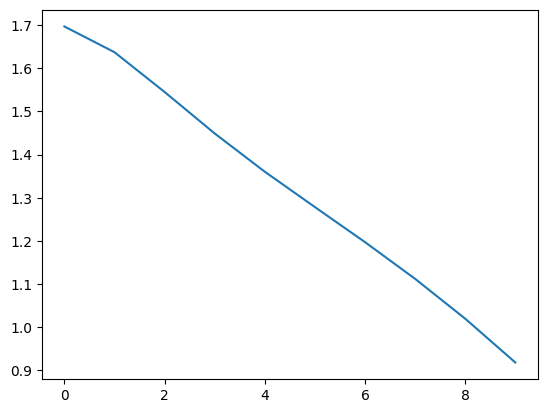

In [20]:
plt.plot(history.history['loss'])
plt.show()

#### Lets see how the code is working.

In [21]:
# We will first try with the query above.
gemma_inst.query(query)

Instruction:
দুর্গাপূজার ইতিহাসের সংক্ষিপ্তসার লেখো বাংলা ভাষায়।

**<font color='green'>Response:</font>**
দুর্গাপূজা হল পবিত্র দুর্গা মন্দিরে মহালয়ের প্রতি আশা ও অনুগামী প্রতিবাদের উপর ভিত্তি করে পুরাণের আলোকায়িত  কাহিনী অনুসারে মহিষারাণের বিরুদ্ধে মহিষারাণকে ধ্বংস করার ঘটনাটির উল্লেখ করে একটি পূজা অনুষ্ঠিত করার ইতিহাসের উৎস।  এই পূজার ইতিহাস পুরাণের সাথে জড়িত এবং বর্ণনা দেয়।  এই পূজা বর্তমানে বাংলাদেশ ও ভারতের মহাশয়ের মন্দিরে অনুষ্ঠিত হয়।  

Lets test with a different query. Here I am asking about a renowned Indian writer [Bibhutibhushan Bandyopadhyay](http://https://en.wikipedia.org/wiki/Bibhutibhushan_Bandyopadhyay)

It should produce some result.

In [22]:
#
gemma_inst.query("বাংলার নামকরণের পিছনে কী কী ধারণা রয়েছে?")

Instruction:
বাংলার নামকরণের পিছনে কী কী ধারণা রয়েছে?

**<font color='green'>Response:</font>**
বাংলা শব্দের etymology গুলির মতে, এটি "বঙ্গ" (বঙ্গা) থেকে এসেছে, যা "বঙ্গা river" (বঙ্গের উপত্যকা) বা "বঙ্গের উপত্যকারাণা" (বঙ্গের উপত্যকারাণ) এর অর্থে বর্ণিত।  এটি একটি বড় নদী (যেমন ভারতের গঙ্গা) বা বঙ্গের উপত্যকারাণার অর্থে বর্ণিত।  তবে,  মুঘল সম্রাট আকবরের  সময়কালে  এটি "বাংলা" (বাংলার উপত্যকা)  এর অর্থে ব্যবহার করা শুরু হয়।  

## Save the trained model

In [ ]:
MODEL_NAME = "gemma_bengali_history"
gemma_lm.save_to_preset(MODEL_NAME)

### Upload to Kaggle

In [ ]:
import  kagglehub
from datetime import datetime


kaggle_username = kagglehub.whoami()['username']
date_today = datetime.today().strftime('%Y-%m-%d')

print(kaggle_username)

In [ ]:
MODEL_SLUG = 'bengali_history'

kagglehub.model_upload(
  handle = f"{kaggle_username}/{MODEL_NAME}/keras/{MODEL_SLUG}",
  local_model_dir = MODEL_NAME,
  version_notes = f'Update {date_today}')

## Conclusion

This notebook shows a way on how to train Gemma on any Cultural history.We can work on improving this.


Is this notebook perfect on describing bengali history and culture? Not yet. But we can improve on it as we get more dataset.

* We need to conytinue with the finetuning and need to lower the learning rate.
* What we saw in the dataset is that the distribution of the data is too much. We need to santize the data a little bit more.
* ALso, the evaluation matrix needs to be implemneted for larger dataset.


